# Access Credibility Evaluation Module

## Import package and dataset

In [1]:
import pandas as pd
import numpy as np 
import re

# Read the CSV file
df_real = pd.read_csv("access_credibility_evalution_data.csv")  # real-time data for calculating the credibility

## Preprocessing

### spatial data

In [2]:
# Define the function to assign zone based on level
def assign_zone(row):
    if row['Level'] == 'Ground Floor':
        return row['zone_name'] + '0'
    elif row['Level'] == '1st Floor':
        return row['zone_name'] + '1'
    elif row['Level'] == '2nd Floor':
        return row['zone_name'] + '2'
    elif row['Level'] == '3rd Floor':
        return row['zone_name'] + '3'
    else:
        return row['zone_name']

# Apply the function to create the 'zone' column
df_real['zone'] = df_real.apply(assign_zone, axis=1)

# Display the first few rows of the modified DataFrame
df_real.head()

,ClientMacAddr,Level,lat,lng,localtime,zone_name,zone
0,34:ab:37:0c:20:01,2nd Floor,51.460423,-0.932558,2020-08-11 12:00:14.877 UTC,D,D2
1,34:ab:37:0c:20:01,Ground Floor,51.460494,-0.932944,2020-08-11 14:10:19.076 UTC,G,G0
2,34:ab:37:0c:20:01,Ground Floor,51.460497,-0.932959,2020-08-11 14:12:29.118 UTC,G,G0
3,34:ab:37:0c:20:01,Ground Floor,51.460493,-0.932949,2020-08-11 14:27:03.655 UTC,G,G0
4,34:ab:37:0c:20:01,Ground Floor,51.460488,-0.932926,2020-08-11 14:46:27.954 UTC,G,G0


### temporal data

In [3]:
# get 3 useful column and format localtime column
df_real = df_real.loc[:,['ClientMacAddr','zone', 'localtime']]
df_real['localtime'] = df_real['localtime'].apply(lambda x: re.sub(r'\.\d+\sUTC$| UTC$', '', x))
df_real['localtime'] = pd.to_datetime(df_real['localtime'])

df_real.head()

,ClientMacAddr,zone,localtime
0,34:ab:37:0c:20:01,D2,2020-08-11 12:00:14
1,34:ab:37:0c:20:01,G0,2020-08-11 14:10:19
2,34:ab:37:0c:20:01,G0,2020-08-11 14:12:29
3,34:ab:37:0c:20:01,G0,2020-08-11 14:27:03
4,34:ab:37:0c:20:01,G0,2020-08-11 14:46:27


## Elements in Trust Level

### Ti(S): real-time duration
Represents the duration of the user's $i$-th access event in real-time. It is the time a user spends on a specific session (e.g., accessing a system, building, or area).
$$Ti(S)=localtime[i]−localtime[i+1]$$

In [4]:
# sort dataframe and calculate the time length
df_real = df_real.sort_values(by=['ClientMacAddr', 'localtime']).reset_index(drop=True)
df_real['duration'] = df_real.groupby('ClientMacAddr')['localtime'].diff(periods=-1).dt.total_seconds().reset_index(drop=True)
df_real['duration'] = df_real['duration'].abs()
df_real['duration'] = df_real['duration'].apply(lambda x: x if x <= 14400 else None).reset_index(drop=True)
df_real.head()

,ClientMacAddr,zone,localtime,duration
0,00:00:00:00:00:00,H0,2020-07-07 08:35:58,10.0
1,00:00:00:00:00:00,H0,2020-07-07 08:36:08,NaN
2,00:00:00:00:00:00,G0,2020-07-08 10:01:39,10.0
3,00:00:00:00:00:00,H0,2020-07-08 10:01:49,111.0
4,00:00:00:00:00:00,G0,2020-07-08 10:03:40,NaN


List out 2-item path for each event

In [5]:
df_real['date'] = df_real['localtime'].dt.date

# Initialize list for 2-item paths
two_item_paths = []

# Group by ClientMacAddr and date
for (client, day), group in df_real.groupby(['ClientMacAddr', 'date']):
    group = group.reset_index(drop=True)  # Reset index for slicing within the group
    for index in range(len(group)):
        if index + 1 >= len(group) or pd.isna(group.loc[index, "duration"]):  # Check for NaN or last row
            two_item_paths.append([])  # Append empty paths for 2-item list
        else:
            # Generate 2-item path for current and next
            two_item_paths.append(list(group.loc[index:index + 1, 'zone']))

# Assign the computed paths back to the DataFrame
df_real['path'] = two_item_paths
df_real['path'] = df_real['path'].apply(tuple)

# Display the first 20 rows
df_real.head()

,ClientMacAddr,zone,localtime,duration,date,path
0,00:00:00:00:00:00,H0,2020-07-07 08:35:58,10.0,2020-07-07,"(H0, H0)"
1,00:00:00:00:00:00,H0,2020-07-07 08:36:08,NaN,2020-07-07,()
2,00:00:00:00:00:00,G0,2020-07-08 10:01:39,10.0,2020-07-08,"(G0, H0)"
3,00:00:00:00:00:00,H0,2020-07-08 10:01:49,111.0,2020-07-08,"(H0, G0)"
4,00:00:00:00:00:00,G0,2020-07-08 10:03:40,NaN,2020-07-08,()


### ΔT: time slicing
- Divides time into predefined slots ($ΔT$), making it easier to analyze user behavior over time.
- Time slices and weighted:
    -  **Slot 1**: 23:01 – 05:00    -> 0.1
    - **Slot 2**: 05:01 – 08:00     -> 0.2
    - **Slot 3**: 08:01 – 17:00     -> 0.5
    - **Slot 4**: 17:01 – 23:00     -> 0.2


In [6]:
# Define a function to assign time slots based on the hour of the day
def assign_time_slot(localtime):
    hour = localtime.hour
    if 23 <= hour or hour < 5:
        return 1  # 23:01 - 05:00
    elif 5 <= hour < 8:
        return 2  # 05:01 - 08:00
    elif 8 <= hour < 17:
        return 3  # 08:01 - 17:00
    elif 17 <= hour < 23:
        return 4  # 17:01 - 23:00

def assign_theta(localtime):
    hour = localtime.hour
    if 23 <= hour or hour < 5:
        return 0.1  # 23:01 - 05:00
    elif 5 <= hour < 8:
        return 0.2  # 05:01 - 08:00
    elif 8 <= hour < 17:
        return 0.5   # 08:01 - 17:00
    elif 17 <= hour < 23:
        return 0.2  # 17:01 - 23:00

# Apply the function to calculate the time slot
df_real['time_slot'] = df_real['localtime'].apply(assign_time_slot)
df_real['theta'] = df_real['localtime'].apply(assign_theta)

df_real = df_real.loc[:,~df_real.columns.isin(['zone', 'localtime', 'date'])].dropna().reset_index(drop=True)
df_real.head()

,ClientMacAddr,duration,path,time_slot,theta
0,00:00:00:00:00:00,10.0,"(H0, H0)",3,0.5
1,00:00:00:00:00:00,10.0,"(G0, H0)",3,0.5
2,00:00:00:00:00:00,111.0,"(H0, G0)",3,0.5
3,00:00:00:00:00:00,9.0,"(G0, H0)",2,0.2
4,00:00:00:00:00:00,114.0,"(H0, J0)",2,0.2


### Tj(L): historical average duration
Represents the average duration of the $j$-th frequent access event. It is derived from historical data to define typical behavior patterns.

In [7]:
df_hist = pd.read_csv("historical_avg_time.csv", usecols=['path','time_slot','avg_time'])
df_hist['path'] = df_hist['path'].apply(lambda x: tuple(x.split(',')))
df_hist.head()

,path,time_slot,avg_time
0,"(A0, A0)",1,101.508772
1,"(A0, A0)",2,74.368421
2,"(A0, A0)",3,80.960463
3,"(A0, A0)",4,45.819525
4,"(A0, A1)",3,38.666667


### δ(P(S),P(L)): 2-itemset path scoring
- Spatial constraint

In [8]:
df_freq = pd.read_csv("frequent_path_mining.csv", usecols=['path','delta'])
df_freq['path'] = df_freq['path'].apply(lambda x: tuple(x.split(',')))
df_freq

,path,delta
0,"(Y0, Y0)",0.231824
1,"(Y0, T0)",0.157741
2,"(T0, Y0)",0.157130
3,"(T0, T0)",0.154111
4,"(X0, Y0)",0.130498
...,...,...
2544,"(F1, C3)",0.001028
2545,"(M0, B0)",0.001028
2546,"(Y2, G3)",0.001028
2547,"(M2, Y2)",0.001028


## Calculate Trust Level

In [9]:
merged_df = pd.merge(df_real, df_hist, how='left',left_on=['path','time_slot'], right_on=['path','time_slot'])
merged_df = pd.merge(merged_df, df_freq, how='left',left_on=['path'], right_on=['path'])
merged_df = merged_df.fillna(0)
merged_df.head()

,ClientMacAddr,duration,path,time_slot,theta,avg_time,delta
0,00:00:00:00:00:00,10.0,"(H0, H0)",3,0.5,40.830303,0.049828
1,00:00:00:00:00:00,10.0,"(G0, H0)",3,0.5,64.325936,0.044174
2,00:00:00:00:00:00,111.0,"(H0, G0)",3,0.5,53.527402,0.044720
3,00:00:00:00:00:00,9.0,"(G0, H0)",2,0.2,162.741667,0.044174
4,00:00:00:00:00:00,114.0,"(H0, J0)",2,0.2,101.846154,0.007485


In [10]:
# make sure there's no NaN
merged_df.isna().sum()

ClientMacAddr    0
duration         0
path             0
time_slot        0
theta            0
avg_time         0
delta            0
dtype: int64

In [11]:
# Duration * Theta (weighted time constraints)
merged_df['duration_theta'] = abs(merged_df['duration'] - merged_df['avg_time'])*merged_df['theta']
merged_df.head()

,ClientMacAddr,duration,path,time_slot,theta,avg_time,delta,duration_theta
0,00:00:00:00:00:00,10.0,"(H0, H0)",3,0.5,40.830303,0.049828,15.415152
1,00:00:00:00:00:00,10.0,"(G0, H0)",3,0.5,64.325936,0.044174,27.162968
2,00:00:00:00:00:00,111.0,"(H0, G0)",3,0.5,53.527402,0.044720,28.736299
3,00:00:00:00:00:00,9.0,"(G0, H0)",2,0.2,162.741667,0.044174,30.748333
4,00:00:00:00:00:00,114.0,"(H0, J0)",2,0.2,101.846154,0.007485,2.430769


$$
\text{Trust} = \frac{\sum\sum (\Delta T\cdot δ(P(S),P(L)) \cdot |Ti(S) - Tj(L)|)}{\sum\sum (δ(P(S),P(L)) \cdot |Ti(S) - Tj(L)|)}
$$

In [12]:
# calculate trust score for each ClientMacAddr
trust_per_client = merged_df.groupby('ClientMacAddr').apply(
    lambda x: (x['duration_theta'] * x['delta']).sum() / (x['duration_theta'] ).sum()
).reset_index(name='Trust')

/var/folders/zt/qht50w6j447fls7gpw2y5hbm0000gn/T/ipykernel_36774/3400900704.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trust_per_client = merged_df.groupby('ClientMacAddr').apply(


In [13]:
# Standarized the result
trust_mean = trust_per_client['Trust'].mean()
trust_std = trust_per_client['Trust'].std()

trust_per_client['Standardized_Trust'] = (
    trust_per_client['Trust'] - trust_mean
) / trust_std

trust_per_client.head()

,ClientMacAddr,Trust,Standardized_Trust
0,00:00:00:00:00:00,0.030291,-0.525304
1,00:06:c6:5a:a2:51,0.052622,-0.116112
2,00:08:22:00:b9:fb,0.039065,-0.364527
3,00:08:22:0a:b9:fb,0.045320,-0.249922
4,00:08:22:0c:bc:fb,0.038462,-0.375587


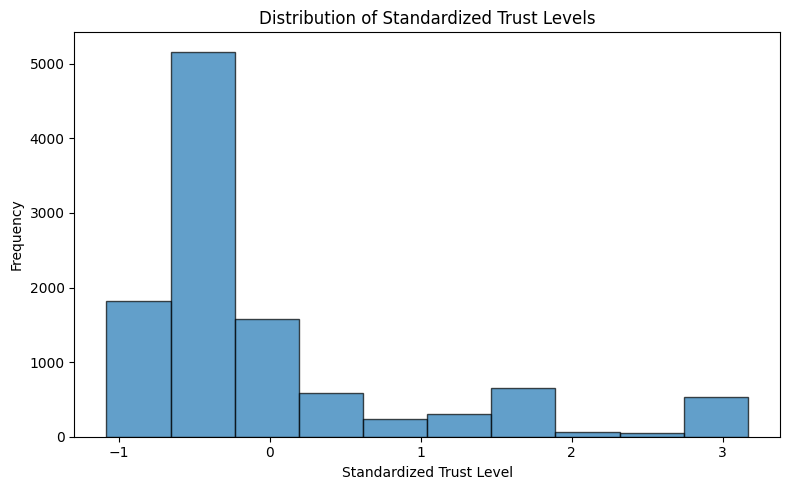

In [14]:
import matplotlib.pyplot as plt

# Plot the distribution of standardized trust levels
plt.figure(figsize=(8, 5))
plt.hist(trust_per_client['Standardized_Trust'], bins=10, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Standardized Trust Level')
plt.ylabel('Frequency')
plt.title('Distribution of Standardized Trust Levels')

# Display the chart
plt.tight_layout()
plt.show()